### Load the imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math, re, string, nltk, html
nltk.download("stopwords")
from wordcloud import WordCloud 
from collections import Counter 
%matplotlib inline

[nltk_data] Downloading package stopwords to C:\Users\Wan
[nltk_data]     Yit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load the dataset (train, test, validation datasets)

In [2]:
data_train = pd.read_csv("Dataset/Constraint_Train.csv") #Load the tweet training set
print("Size of Dataset: ", data_train.shape)
data_train.sample(5)

Size of Dataset:  (6420, 3)


id                                              tweet label
4830  4831  A worker at a #coronavirus testing centre has ...  real
1430  1431  Contact tracing is essential to slowing the sp...  real
2577  2578  Some of the testing fall off is attributable t...  real
3288  3289  It looks to us like Indiana has to be added to...  real
1529  1530  Colorado Denies That Traces of The Coronavirus...  fake

In [3]:
data_val = pd.read_csv("Dataset/Constraint_Val.csv") #Load the tweet validation set
print("Size of Dataset: ", data_val.shape)
data_val.sample(5)

Size of Dataset:  (2140, 3)


id                                              tweet label
318    319  RT @CDCDirector: As the number of people in ou...  real
1717  1718  New fears for Boris mental health as he claims...  fake
917    918  There are 104 linked to the community cluster ...  real
1932  1933  @he11totheno Not a day! Cumulative. But you're...  real
1911  1912  The percent of tests coming back positive is r...  real

In [4]:
data_test = pd.read_csv("Dataset/english_test_with_labels.csv") #Load the tweet testing set
print("Size of Dataset: ", data_test.shape)
data_test.sample(5)

Size of Dataset:  (2140, 3)


id                                              tweet label
1034  1035  #JoniErnst\r\n\r\nTHE REAL AMOUNT OF FATALITIE...  fake
2066  2067  If you can hold your breath for 10 seconds wit...  fake
1736  1737  “The review of #COVID19 trends in Africa shows...  real
778    779  Michigan continues to be a real trouble spot a...  real
969    970  _A vaccine has been developed that cures Covid...  fake

### Check for Null Values in each dataset

In [5]:
print("Training dataset:")
print(data_train.isnull().any())
print("\nTesting dataset:")
print(data_test.isnull().any())
print("\nValidation dataset:")
print(data_val.isnull().any())

# I notice that there are no null values in the every datasets

Training dataset:
id       False
tweet    False
label    False
dtype: bool

Testing dataset:
id       False
tweet    False
label    False
dtype: bool

Validation dataset:
id       False
tweet    False
label    False
dtype: bool


### Data Exploration
- Check what do each dataset contain
- Count the label for training and validation dataset
- See some example from each datasets.

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB


In [7]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB


Training Labels:
real    3360
fake    3060
Name: label, dtype: int64

Validation Labels:
real    1120
fake    1020
Name: label, dtype: int64

Test Labels:
real    1120
fake    1020
Name: label, dtype: int64


Text(0.5, 1.0, 'Test Dataset Label')

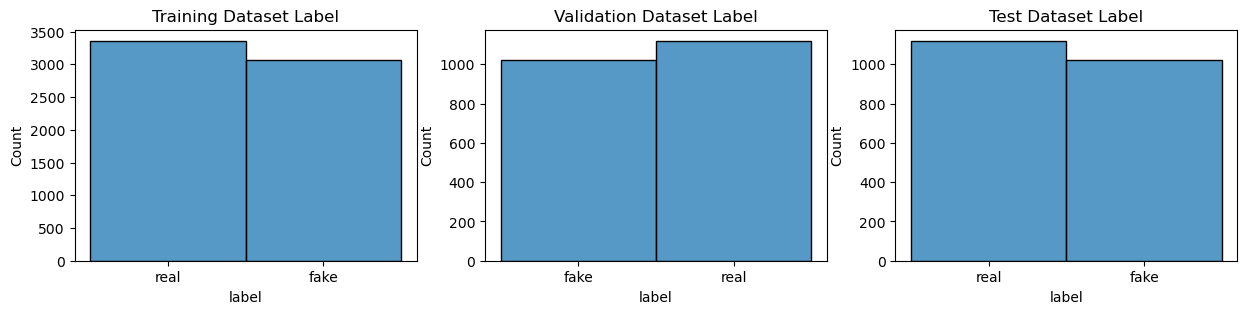

In [9]:
print("Training Labels:")
print(data_train["label"].value_counts())
print("\nValidation Labels:")
print(data_val["label"].value_counts())
print("\nTest Labels:")
print(data_test["label"].value_counts())

fig, d = plt.subplots(1, 3, figsize=(15,3))

sns.histplot(x =data_train["label"], ax = d[0])
d[0].set_title("Training Dataset Label")
sns.histplot(data_val["label"], ax = d[1])
d[1].set_title("Validation Dataset Label")
sns.histplot(data_test["label"], ax = d[2])
d[2].set_title("Test Dataset Label")

# I noticed that the labels actually appear to be quite balanced in number, 
#   this means that the model should pick up these labels without too much trouble.

# The label is shown as 'real / fake', so I decided to change the label into 1 and 0 
#   for easier modeling. 

In [10]:
print(data_train["tweet"][0])
print("")
print(data_train["tweet"][1000])
print("")
print(data_train["tweet"][3000])

# From below, I noticed that some of the tweets contains hashtags and links which 
#   might effect the further prediction. So I will have to do more cleaning in 
#   the datasets.

The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.

About antibody testing... 1) It is necessary to separate out these tests. 2) Antibody testing remains a small portion of the cumulative tests performed. 2) US viral testing really has scaled up a ton. 4) Antibody tests have grown as a % of daily tests. Colorado e.g.: https://t.co/sCyn5aASMV

???if your child gets this virus their going to hospital alone in a van with people they don???t know...to be with people they don???t know??? you will be at home without them in their time of need.??�


### Create some function
- Word Cloud function
- Concat all sentences (replace the regex with space and link them into one string)
- Clean the tweet

In [11]:
# Punctuations lists to remove
punctuation = string.punctuation
print(punctuation)

# NLTK stopwords that provided
STOP = nltk.corpus.stopwords.words("english")
print(STOP)


# Since string and nltk library already provide the punctuation and stopword for 
#   easier life, I decided to use the library that already provided out there 
#   instead of hard-coding the list. 

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only

In [12]:
def word_cloud(tokens):
  wordcloud = WordCloud(width = 400, height = 400, 
            background_color ='black',  
            min_font_size = 10).generate(tokens) 

  # plot the WordCloud image                        
  plt.figure(figsize = (6, 6), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  return plt

In [13]:
def clean_tweet(tweet):
  for i in range(0,len(tweet)):
    t = tweet[i]
    # Remove html elements
    t = html.unescape(t) 
    # Removes @'s (eg. Susan's), as peoples' usernames mean nothing
    t = re.sub(r"@\w+", " ", t)
    # Removes links contain in the tweet as link itself doesn't provide useful data
    t = re.sub(r"http\S+", " ", t)
    # Remove the punctuation defined before
    t = "".join([punc for punc in t if not punc in punctuation])
    # Change the word into lowercase
    t = t.lower()
    # Split the tweet into single word
    w = t.split()
    # Remove the stop word that defined before if occured
    tweet[i] = "".join([word + " " for word in w if not word in STOP])

  return tweet


def clean_tweet2(tweet):
  t = tweet
  # Remove html elements
  t = html.unescape(t) 
  # Removes @'s (eg. Susan's), as peoples' usernames mean nothing
  t = re.sub(r"@\w+", " ", t)
  # Removes links contain in the tweet as link itself doesn't provide useful data
  t = re.sub(r"http\S+", " ", t)
  # Remove the punctuation defined before
  t = "".join([punc for punc in t if not punc in punctuation])
  # Change the word into lowercase
  t = t.lower()
  # Split the tweet into single word
  w = t.split()
  # Remove the stop word that defined before if occured
  tweet = "".join([word + " " for word in w if not word in STOP])

  return tweet


# For the word cleaning process, I choose to leave the numbers inside the dataset 
#   as since that 'Covid-19' itself already contain number. The usage of this phrase
#   considered high.

In [14]:
def concat_all(tweet):
  all_tweet = ''
  for text in tweet:
    all_tweet += text + " "
  return all_tweet

### Tweet Data Processing (Data Cleaning)

In [15]:
# Clean the dataset using the function we created.
data_train["cleanT"] = clean_tweet(data_train["tweet"].copy())
data_train.head(5)

id                                              tweet label  \
0   1  The CDC currently reports 99031 deaths. In gen...  real   
1   2  States reported 1121 deaths a small rise from ...  real   
2   3  Politically Correct Woman (Almost) Uses Pandem...  fake   
3   4  #IndiaFightsCorona: We have 1524 #COVID testin...  real   
4   5  Populous states can generate large case counts...  real   

                                              cleanT  
0  cdc currently reports 99031 deaths general dis...  
1  states reported 1121 deaths small rise last tu...  
2  politically correct woman almost uses pandemic...  
3  indiafightscorona 1524 covid testing laborator...  
4  populous states generate large case counts loo...

In [16]:
data_val["cleanT"] = clean_tweet(data_val["tweet"].copy())
data_val.sample(5)

id                                              tweet label  \
1125  1126  Yesterday our laboratories processed 6938 test...  real   
626    627  Yesterday our laboratories processed 8185 test...  real   
1543  1544  Coronavirus patients with preexisting mental h...  real   
689    690  General Funk announces 20 new fundamentals in ...  fake   
2005  2006  Boris Johnson shopping in England in the time ...  fake   

                                                 cleanT  
1125  yesterday laboratories processed 6938 tests br...  
626   yesterday laboratories processed 8185 tests br...  
1543  coronavirus patients preexisting mental health...  
689   general funk announces 20 new fundamentals res...  
2005   boris johnson shopping england time coronavirus

In [17]:
data_test["cleanT"] = clean_tweet(data_test["tweet"].copy())
data_test.sample(5)

id                                              tweet label  \
1462  1463  📢#CoronaVirusUpdates: 📍#COVID19 India Tracker ...  real   
433    434  #IndiaFightsCorona: India's #COVID19 Cases per...  real   
1232  1233  Everyone should ensure their mouth and throat ...  fake   
935    936  In the next couple weeks we will have a dedica...  real   
655    656  Coronavirus: Donald Trump ignores COVID-19 rul...  real   

                                                 cleanT  
1462  📢coronavirusupdates 📍covid19 india tracker 04 ...  
433   indiafightscorona indias covid19 cases per mil...  
1232  everyone ensure mouth throat moist never dry a...  
935   next couple weeks dedicated page covid racial ...  
655   coronavirus donald trump ignores covid19 rules...

In [18]:
# See example before and after cleaning the text
print(data_train["tweet"][2801])
print("")
print(data_train["cleanT"][2801])

# The clean data already remove the links and "common word"(Stop words) but still 
#   remain the numbers(numerical digits)

Our daily update is published. States reported 798k tests and 65k new cases of COVID-19. States reported 1037 deaths today which was our fifth day in a row of more than 1000 COVID-19 deaths in the United States. https://t.co/g3dYnZZapt

daily update published states reported 798k tests 65k new cases covid19 states reported 1037 deaths today fifth day row 1000 covid19 deaths united states 


### Check for Null value in case the tweet might only contain username and links 

In [19]:
print("Training dataset:")
print(data_train.isnull().any())
print("\nTesting dataset:")
print(data_test.isnull().any())
print("\nValidation dataset:")
print(data_val.isnull().any())

Training dataset:
id        False
tweet     False
label     False
cleanT    False
dtype: bool

Testing dataset:
id        False
tweet     False
label     False
cleanT    False
dtype: bool

Validation dataset:
id        False
tweet     False
label     False
cleanT    False
dtype: bool


### Create word cloud for the datasets for better visualisation. 

In [20]:
data_both = pd.concat([data_train, data_val, data_test])
print("Size of Dataset: ", data_both.shape)
print("\nLabels:")
print(data_both["label"].value_counts())

Size of Dataset:  (10700, 4)

Labels:
real    5600
fake    5100
Name: label, dtype: int64


In [21]:
data_all = data_both['cleanT']
data_real = data_both[data_both['label'] == 'real']['cleanT']
data_fake = data_both[data_both['label'] == 'fake']['cleanT']

all_s = concat_all(data_all)
real_s = concat_all(data_real)
fake_s = concat_all(data_fake)

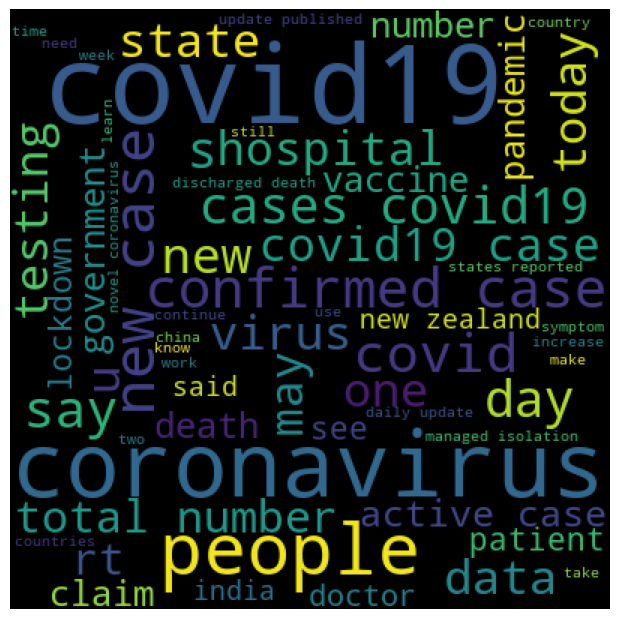

In [22]:
fig_all = word_cloud(all_s)

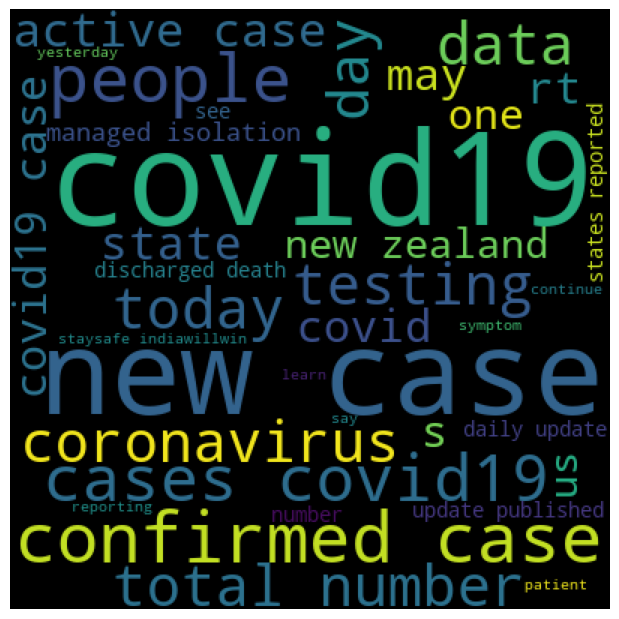

In [23]:
fig_real = word_cloud(real_s)

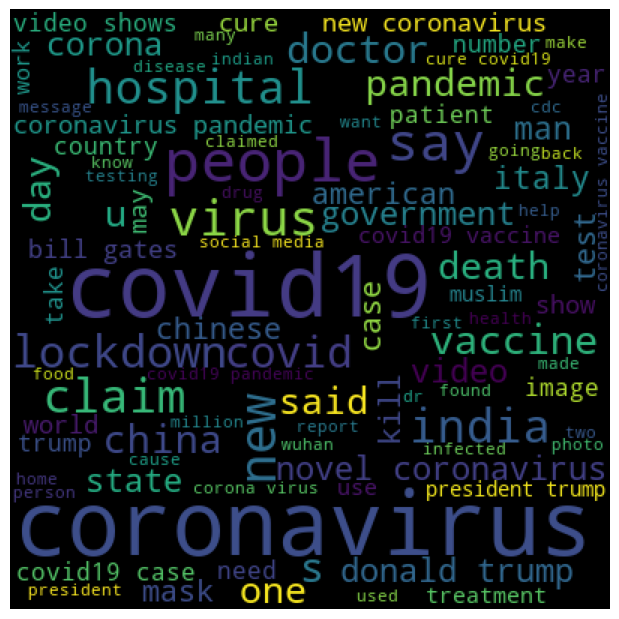

In [24]:
fig_fake = word_cloud(fake_s)

### Label Encoding (Repharse the label into number instead or string)

In [25]:
# Choose 'real' as the encoded values, so it will appeared as one
data_train["new_label"] = pd.get_dummies(data_train["label"])["real"]
data_train.sample(5)

id                                              tweet label  \
2400  2401  Our estimates suggest that once an effective #...  real   
1520  1521  Trump said increased testing has led to more c...  fake   
2840  2841  As India detected more #COVID19 cases in Mar-A...  fake   
6271  6272  Thirty-four new cases of #COVID19 have been re...  real   
2106  2107  #CoronaVirusUpdates: #COVID19 testing status u...  real   

                                                 cleanT  new_label  
2400  estimates suggest effective covid19 vaccine di...          1  
1520  trump said increased testing led cases halting...          0  
2840  india detected covid19 cases marapr 2020 fake ...          0  
6271  thirtyfour new cases covid19 reported follows ...          1  
2106  coronavirusupdates covid19 testing status upda...          1

In [26]:
data_val["new_label"] = pd.get_dummies(data_val["label"])["real"]
data_val.sample(5)

id                                              tweet label  \
937    938  Yesterday our laboratories completed 2574 test...  real   
749    750            Jair Bolsonaro has the new coronavirus.  fake   
371    372  RT @drharshvardhan: #COVID19 UPDATE 👉1054 case...  real   
469    470  The Brazilian state of Ceará had more deaths f...  fake   
1627  1628  There have now been 25 COVID-19 related deaths...  real   

                                                 cleanT  new_label  
937   yesterday laboratories completed 2574 tests br...          1  
749                     jair bolsonaro new coronavirus           0  
371   rt covid19 update 👉1054 case fatalities report...          1  
469   brazilian state ceará deaths respiratory disea...          0  
1627  25 covid19 related deaths new zealand thoughts...          1

In [27]:
data_test["new_label"] = pd.get_dummies(data_test["label"])["real"]
data_test.sample(5)

id                                              tweet label  \
1085  1086  Claim that Fox news said that Trump tested pos...  fake   
2115  2116  ???China is to blame because the culture where...  fake   
1677  1678  Workers who worked from 1990 to 2020 have the ...  fake   
100    101  RT @mygovindia: India crosses 1 Million landma...  real   
735    736  Hindus cast their idols in the sea because the...  fake   

                                                 cleanT  new_label  
1085  claim fox news said trump tested positive covi...          0  
2115  china blame culture people eat bats snakes dog...          0  
1677  workers worked 1990 2020 right receive corona ...          0  
100   rt india crosses 1 million landmark covid19 te...          1  
735           hindus cast idols sea defend coronavirus           0

### Small test before fit in the model. 
- In this part, there will randomly chosen articles from the dataset. Let try to see how well humans would be able to classify the articles as being real or fake news. 
- The label will be provide at the end for each articles.

In [28]:
data_sample = data_both.sample(n = 5, random_state = 15)

eg1 = data_sample.iloc[0]["tweet"]
eg2 = data_sample.iloc[1]["tweet"]
eg3 = data_sample.iloc[2]["tweet"]
eg4 = data_sample.iloc[3]["tweet"]
eg5 = data_sample.iloc[4]["tweet"]

print("Example 1: ")
print(eg1)

Example 1: 
A post shared more than a thousand times on Facebook claims that a corpse of a COVID-19 positive person is 100 times more “toxic” 72 hours after death -- and that because undertakers are not burying bodies within this prescribed period funerals have become hotspots for further infections.


In [29]:
print("Example 2: ")
print(eg2)

Example 2: 
The latest CDC #COVIDView report shows that the percentage of people testing positive nationally for #COVID19 continues to increase particularly in the Southeast Southwest/coast and South-central parts of the country. Learn more: https://t.co/zP4VYlo0Pb https://t.co/gqvEO6ZsZw


In [30]:
print("Example 3: ")
print(eg3)

Example 3: 
Man Becomes Fluent In Spanish, Completes Physics Degree &amp; Learns To Code While Patiently Waiting For Covid-19 Test Result https://t.co/yqLzdmKxjF


In [31]:
print("Example 4: ")
print(eg4)

Example 4: 
Says Donald Trump was caught on a hot mic insulting his supporters.


In [32]:
print("Example 5: ")
print(eg5)

Example 5: 
A #coronavirus testing centre in Kent has been shut - reportedly to make way for a lorry park in the run up to the next big Brexit deadline https://t.co/FaQTTuRLLK


In [33]:
# Answer for the sample data. 
display(data_sample)

# So Example number 2 and 5 are real news, how well did human able to know?
# Now lets fit the dataset into the model. 

id                                              tweet label  \
689    690  A post shared more than a thousand times on Fa...  fake   
2530  2531  The latest CDC #COVIDView report shows that th...  real   
5811  5812  Man Becomes Fluent In Spanish, Completes Physi...  fake   
4947  4948  Says Donald Trump was caught on a hot mic insu...  fake   
1959  1960  A #coronavirus testing centre in Kent has been...  real   

                                                 cleanT  
689   post shared thousand times facebook claims cor...  
2530  latest cdc covidview report shows percentage p...  
5811  man becomes fluent spanish completes physics d...  
4947  says donald trump caught hot mic insulting sup...  
1959  coronavirus testing centre kent shut reportedl...

### Drop extra columns and Import all data into one new dataset

In [34]:
clean_data = pd.concat([data_test, data_train, data_val], sort = True)

clean_data.drop(["tweet", "label"], axis =1, inplace = True)
clean_data.info()
clean_data.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cleanT     10700 non-null  object
 1   id         10700 non-null  int64 
 2   new_label  10700 non-null  uint8 
dtypes: int64(1), object(1), uint8(1)
memory usage: 261.2+ KB


cleanT    id  new_label
676   rt neil ferguson imperial produce model sweden...   677          1
1950  rt covid19 update 👉 1132 case fatalities repor...  1951          1
1865    40 flight crash victims test positive covid 19   1866          0
389   chairman republican party texas said recovery ...   390          0
1789  307 new cases covid19 lagos188 fct44 ogun19 ka...  1790          1

### Feature Extracting 

In [35]:
# Etracting feature words using tfidf and count vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
x1 = tfidf.fit_transform(clean_data["cleanT"])

count_v = CountVectorizer()
x2 = count_v.fit_transform(clean_data["cleanT"])

y = clean_data["new_label"]

In [36]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x1, y, test_size=0.33)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y, test_size=0.33)

## Model Building
I will try 4 different model to solve the classification task:
- Naive Bayes
- Support Vector Machine (SVMs)
- Logistic Regression
- Decision Tree
- Random Forest

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

scores = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Precision", "Recall", "F1-score"])

# Create function for displaying the prediction detail
def result_display(num, model, vect, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: ", acc)
    print("")
    print(classification_report(y_test, y_pred))
    print("")

    cm = confusion_matrix(y_test, y_pred)
    cm_dis = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= [False, True])
    
    fig, ax = plt.subplots(figsize=(4,3))
    cm_dis.plot(cmap=plt.cm.Blues, ax = ax, values_format='.5g')
    ax.set_title("Confusion Matrix")

    clr = classification_report(y_test, y_pred, output_dict = True)['macro avg']
    plt.show
    scores.loc[num] = [model, vect, acc, clr['precision'], clr['recall'], clr['f1-score']]


In [38]:
from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')
import lime
import lime.lime_tabular


### Naive Bayes model

Accuracy:  0.9028603794958935

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1699
           1       0.87      0.95      0.91      1832

    accuracy                           0.90      3531
   macro avg       0.91      0.90      0.90      3531
weighted avg       0.91      0.90      0.90      3531




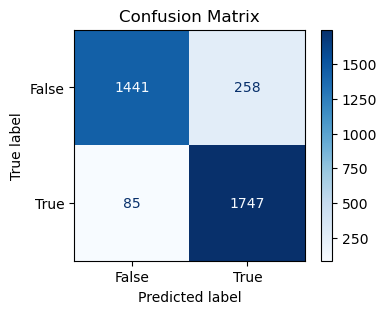

In [39]:
# Naive Bayes - Tfidf Vectorizer
from sklearn.naive_bayes import MultinomialNB

nb_tf = MultinomialNB()
nb_tf.fit(x_train, y_train)

pred_nb_tf = nb_tf.predict(x_test)

result_display(1, 'Naive Bayes', 'Tfidf', y_test, pred_nb_tf)

Accuracy:  0.9127725856697819

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1708
           1       0.92      0.91      0.92      1823

    accuracy                           0.91      3531
   macro avg       0.91      0.91      0.91      3531
weighted avg       0.91      0.91      0.91      3531




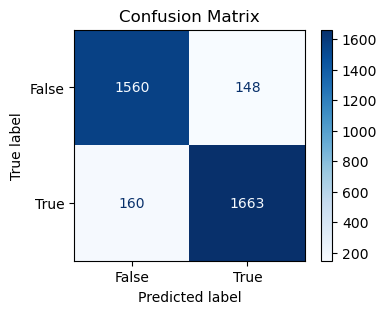

In [40]:
# Naive Bayes - Count Vectorizer
nb_cv = MultinomialNB()
nb_cv.fit(x_train2, y_train2)

pred_nb_cv = nb_cv.predict(x_test2)

result_display(2, 'Naive Bayes', 'Count', y_test2, pred_nb_cv)

### Support Vector Machine (SVMs)

Accuracy:  0.9345794392523364

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1699
           1       0.94      0.94      0.94      1832

    accuracy                           0.93      3531
   macro avg       0.93      0.93      0.93      3531
weighted avg       0.93      0.93      0.93      3531


Top 10 Most Important Features with SVMs Model with TF-IDF vectorizer:
1.9533871819200521  --->  risk
2.153091868971151  --->  restrictions
2.1994467260297825  --->  data
2.264552837881471  --->  covid19nigeria
2.349310795943928  --->  discharged
2.4294647752105964  --->  latest
2.7952606556613646  --->  learn
3.188483100477508  --->  via
3.3282289355291717  --->  indiafightscorona
3.937767063861634  --->  rt


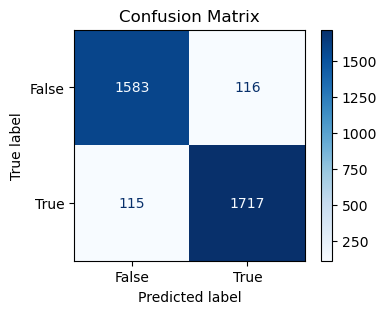

In [41]:
# SVM with Tfidf Vectorizer
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(x_train, y_train)

pred_svm_tf = model.predict(x_test)

result_display(3, 'Linear SVC', 'Tfidf', y_test, pred_svm_tf)

model = SVC(kernel='linear', probability=True)
model.fit(x_train, y_train)

# Get the coefficients (weights) of the Linear SVM
coefficients = model.coef_.toarray()  # Convert to a dense array

# Get feature names from the TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

# Find the top N most important features
N = 10
top_features_idx = np.argsort(coefficients[0])[-N:]

# Print the top N most important features and their coefficients
print("Top", N, "Most Important Features with SVMs Model with TF-IDF vectorizer:")
for idx in top_features_idx:
    print(coefficients[0][idx], " ---> ", feature_names[idx])

Accuracy:  0.9345794392523364

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1699
           1       0.94      0.94      0.94      1832

    accuracy                           0.93      3531
   macro avg       0.93      0.93      0.93      3531
weighted avg       0.93      0.93      0.93      3531


Top 10 Most Important Features:
nigeria  --->  1.702721202571298
restrictions  --->  1.7564653928773553
data  --->  1.7672856517700026
latest  --->  1.9721156999064862
discharged  --->  2.0063238733128017
covid19nigeria  --->  2.097288561775884
learn  --->  2.280878909941463
via  --->  2.487144739446781
indiafightscorona  --->  2.879158012617075
rt  --->  3.1474733277772895


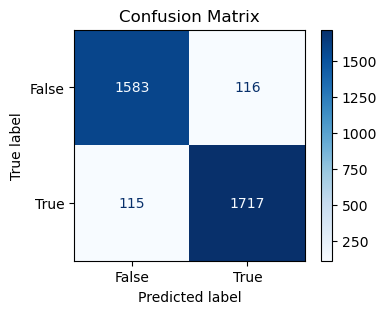

In [42]:
# SVM with Tfidf Vectorizer
from sklearn.svm import LinearSVC

svm_tf = LinearSVC()
svm_tf.fit(x_train, y_train)

pred_svm_tf = svm_tf.predict(x_test)

result_display(3, 'Linear SVC', 'Tfidf', y_test, pred_svm_tf)

coefficients = svm_tf.coef_ # Convert to a dense array

# Get feature names from the TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

# Find the top N most important features
N = 10
top_features_idx = np.argsort(coefficients[0])[-N:]

# Print the top N most important features and their coefficients
print("Top", N, "Most Important Features:")
for idx in top_features_idx:
    print(feature_names[idx], " ---> ", coefficients[0][idx])

In [43]:
class_names = ['false', 'true']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
#3529,777, 2389, 2468

sample_vector = x_test[0]
sample = 'Some busters about COVID-19: spraying of alcohol or chlorine over the body will not kill viruses; drinking alcohol smoking or eating garlic does not protect you from COVID-19; sesame oil does not kill it'
sample_text = ' '.join([feature_name for feature_name, feature_value in zip(tfidf.get_feature_names_out(), sample_vector.toarray()[0]) if feature_value > 0])
from sklearn.pipeline import make_pipeline
c = make_pipeline(tfidf, model)

clean_s = clean_tweet2(sample)
# print(sample_text)
exp = explainer.explain_instance(clean_s, c.predict_proba)
exp.as_list()

[('alcohol', -0.030768864513268327),
 ('chlorine', -0.021584463864748545),
 ('kill', -0.020467090921209574),
 ('eating', -0.017016339762366117),
 ('protect', 0.014301105149312553),
 ('smoking', 0.008319091098306365),
 ('viruses', -0.007544262857658086),
 ('spraying', -0.0058302681162916885),
 ('sesame', 0.00299396762364143),
 ('body', -0.0026240664419417323)]

In [44]:
exp.show_in_notebook(text=True)

Accuracy:  0.9139054092325121

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1708
           1       0.92      0.91      0.92      1823

    accuracy                           0.91      3531
   macro avg       0.91      0.91      0.91      3531
weighted avg       0.91      0.91      0.91      3531




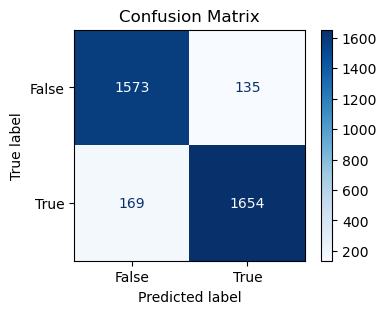

In [45]:
# SVM with Count Vectorizer
svm_cv = LinearSVC()
svm_cv.fit(x_train2, y_train2)

pred_svm_cv = svm_cv.predict(x_test2)

result_display(4, 'Linear SVC', 'Count', y_test2, pred_svm_cv)



### Logistic Regression

Accuracy:  0.9263664684225432

              precision    recall  f1-score   support

           0       0.92      0.93      0.92      1699
           1       0.94      0.92      0.93      1832

    accuracy                           0.93      3531
   macro avg       0.93      0.93      0.93      3531
weighted avg       0.93      0.93      0.93      3531


Top 10 Most Important Features:
via
today
states
testing
data
tests
learn
cases
indiafightscorona
rt


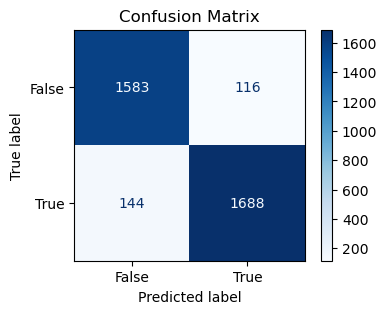

In [46]:
# Logistic Regression with Tfidf Vectorizer
from sklearn.linear_model import LogisticRegression

lg_tf = LogisticRegression()
lg_tf.fit(x_train, y_train)

pred_lg_tf = lg_tf.predict(x_test)

result_display(5, 'Logistic Regression', 'Tfidf', y_test, pred_lg_tf)

coefficients = lg_tf.coef_ # Convert to a dense array

# Get feature names from the TF-IDF vectorizer
feature_names = np.array(tfidf.get_feature_names_out())

# Find the top N most important features
N = 10
top_features_idx = np.argsort(coefficients[0])[-N:]

# Print the top N most important features and their coefficients
print("Top", N, "Most Important Features:")
for idx in top_features_idx:
    print(feature_names[idx])

Accuracy:  0.9226847918436704

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1708
           1       0.94      0.90      0.92      1823

    accuracy                           0.92      3531
   macro avg       0.92      0.92      0.92      3531
weighted avg       0.92      0.92      0.92      3531




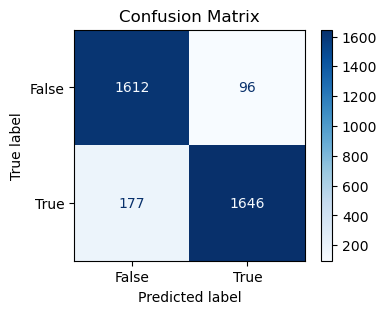

In [47]:
# Logistic Regression with Count Vectorizer
lg_cv = LogisticRegression()
lg_cv.fit(x_train2, y_train2)

pred_lg_cv = lg_cv.predict(x_test2)

result_display(6, 'Logistic Regression', 'Count', y_test2, pred_lg_cv)

### Decision Tree Classifier

Accuracy:  0.8592466723307844

              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1699
           1       0.86      0.87      0.86      1832

    accuracy                           0.86      3531
   macro avg       0.86      0.86      0.86      3531
weighted avg       0.86      0.86      0.86      3531


Top 10 Most Important Features:
covid19
data
covidー19
indiafightscorona
learn
rt
testing
tests
cases
coronavirus


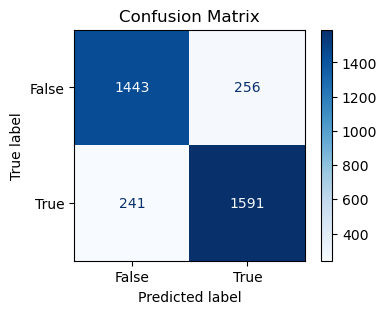

In [48]:
# Decision Tree with Tfidf Vectorizer
from sklearn.tree import DecisionTreeClassifier

dt_tf = DecisionTreeClassifier()
dt_tf.fit(x_train, y_train)

pred_dt_tf = dt_tf.predict(x_test)

result_display(7, 'Decision Tree Classifier', 'Tfidf', y_test, pred_dt_tf)


from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names = np.array(tfidf.get_feature_names_out())
feature_importance = dt_tf.feature_importances_

# Find the top N most important features
N = 10
top_features_idx = np.argsort(feature_importance)[-N:]

# Print the top N most important features and their importance scores
print("Top", N, "Most Important Features:")
for idx in top_features_idx:
    print(feature_names[idx])

In [49]:
print(dt_tf.predict(x_test[0]))

[1]


In [50]:
class_names = ['false', 'true']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)


sample_vector = x_test[0]
sample_text = ' '.join([feature_name for feature_name, feature_value in zip(tfidf.get_feature_names_out(), sample_vector.toarray()[0]) if feature_value > 0])
from sklearn.pipeline import make_pipeline
c = make_pipeline(tfidf, dt_tf)

print(sample_text)
exp = explainer.explain_instance(sample_text, c.predict_proba)
exp.as_list()

completed it northeast noting number tests trending worth


[('tests', 0.9979244006752036),
 ('completed', 0.00011393711054806876),
 ('it', 8.849320739683001e-05),
 ('number', 7.597246090255225e-05),
 ('noting', 2.8827467432631593e-05),
 ('northeast', 2.4395375831354488e-05),
 ('trending', 1.3196210697118788e-05),
 ('worth', -1.1657772889874976e-05)]

In [51]:
exp.show_in_notebook(text=True)

Accuracy:  0.8549985839705466

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1708
           1       0.86      0.85      0.86      1823

    accuracy                           0.85      3531
   macro avg       0.85      0.86      0.85      3531
weighted avg       0.86      0.85      0.86      3531




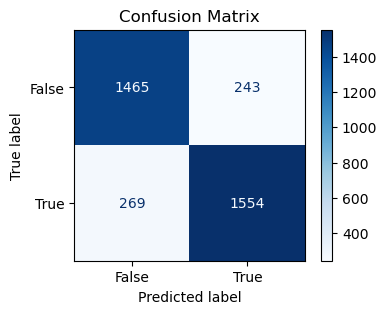

In [52]:
# Decision Tree with Count Vectorizer
dt_cv = DecisionTreeClassifier()
dt_cv.fit(x_train2, y_train2)

pred_dt_cv = dt_cv.predict(x_test2)

result_display(8, 'Decision Tree Classifier', 'Count', y_test2, pred_dt_cv)

### Random Forest Classifier

Accuracy:  0.91928632115548

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1699
           1       0.94      0.90      0.92      1832

    accuracy                           0.92      3531
   macro avg       0.92      0.92      0.92      3531
weighted avg       0.92      0.92      0.92      3531




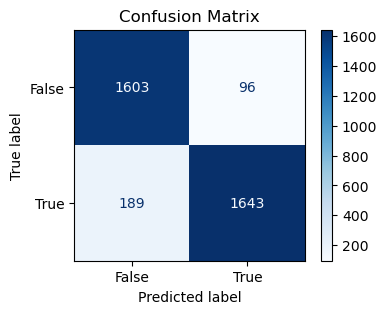

In [53]:
# Random Forest with Tfidf Vectorizer
from sklearn.ensemble import RandomForestClassifier


rf_tf= RandomForestClassifier(n_estimators=100, criterion='entropy')
rf_tf.fit(x_train, y_train)

pred_rf_tf = rf_tf.predict(x_test)

result_display(9, 'Random Forest Classifier', 'Tfidf', y_test, pred_rf_tf)

In [54]:
print(x1[1].toarray())

[[0. 0. 0. ... 0. 0. 0.]]


In [55]:
class_names = ['false', 'true']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)


sample_vector = x_test[0]
sample_text = ' '.join([feature_name for feature_name, feature_value in zip(tfidf.get_feature_names_out(), sample_vector.toarray()[0]) if feature_value > 0])
from sklearn.pipeline import make_pipeline
c = make_pipeline(tfidf, rf_tf)

print(sample_text)
exp = explainer.explain_instance(sample_text, c.predict_proba)
print('Probability =', c.predict_proba([sample_text])[0, 1])

completed it northeast noting number tests trending worth
Probability = 0.74


In [56]:
exp.as_list()
exp.show_in_notebook(text=True)

Accuracy:  0.9116397621070518

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      1708
           1       0.94      0.89      0.91      1823

    accuracy                           0.91      3531
   macro avg       0.91      0.91      0.91      3531
weighted avg       0.91      0.91      0.91      3531




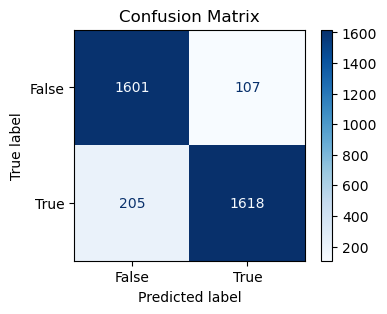

In [57]:
# Random Forest with Count Vectorizer
rf_cv= RandomForestClassifier(n_estimators=100, criterion='entropy')
rf_cv.fit(x_train2, y_train2)

pred_rf_cv = rf_cv.predict(x_test2)

result_display(10, 'Random Forest Classifier', 'Count', y_test2, pred_rf_cv)

## Conclusion

In [58]:
scores

Model Vectorizer  Accuracy  Precision    Recall  \
1                Naive Bayes      Tfidf  0.902860   0.907810  0.900874   
2                Naive Bayes      Count  0.912773   0.912627  0.912791   
3                 Linear SVC      Tfidf  0.934579   0.934495  0.934476   
4                 Linear SVC      Count  0.913905   0.913762  0.914128   
5        Logistic Regression      Tfidf  0.926366   0.926158  0.926561   
6        Logistic Regression      Count  0.922685   0.922976  0.923351   
7   Decision Tree Classifier      Tfidf  0.859247   0.859143  0.858886   
8   Decision Tree Classifier      Count  0.854999   0.854821  0.855085   
9   Random Forest Classifier      Tfidf  0.919286   0.919664  0.920165   
10  Random Forest Classifier      Count  0.911640   0.912230  0.912451   

    F1-score  
1   0.902125  
2   0.912698  
3   0.934485  
4   0.913860  
5   0.926301  
6   0.922678  
7   0.858999  
8   0.854906  
9   0.919276  
10  0.911638